In [1]:
import copy
import itertools
import os
import sys
sys.path.append("/workspace/mta_vision_transformers/")
from collections import OrderedDict
from typing import Any, Callable, Dict, List, Set, Tuple

import matplotlib
import matplotlib.colors
import numpy as np
import einops
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils.data
from matplotlib import pyplot as plt
from tensordict import TensorDict
from torch.utils._pytree import tree_flatten

from core.monitor import Monitor
from infrastructure import utils
from infrastructure.settings import DEVICE, OUTPUT_DEVICE, DTYPE
from dataset.construct import ImageDataset
from dataset.library import DATASETS


dataset_name, n_classes = DATASETS["Common"][1]
OUTPUT_DIR = "experiments/compression"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
# Ocean: 901085904
# Rose: 100390212
torch.set_printoptions(linewidth=400, sci_mode=False)

Seed: 1149496617


Base model
Text-to-Image Retrieval Metrics:
R@1: 39.62%
R@2: 50.40%
R@5: 64.62%
Image-to-Text Retrieval Metrics:
R@1: 36.92%
R@2: 47.74%
R@5: 61.44%

Compression model
partition:
no_partition:


/tmp/ipykernel_113425/2114405807.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_metrics: TensorDict = torch.load(baseline_fname, map_location=DEVICE)
/tmp/ipy

ValueError: too many values to unpack (expected 2)

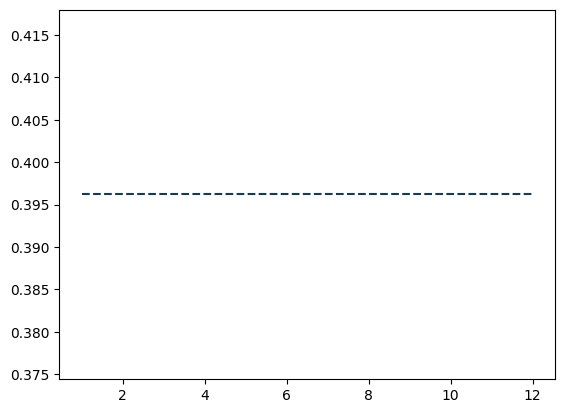

In [ ]:
from dataset.evaluation import ImageTextDataset, run_retrieval_evaluation, print_retrieval_metrics, DEFAULT_DATASET
from modeling.image_features import ImageFeatures
from modeling.openclip_vit import OpenCLIPViT
from modeling.vit_compression import OpenCLIPCompressionViT


utils.reset_seed()
# Run evaluation
evaluation_kwargs: Dict[str, Any] = {"subsample": 5000, "n_ev": 1}

# Evaluate base model
print("=" * 120)
print("Base model")
print("=" * 120)

baseline_fname = f"{OUTPUT_DIR}/metrics/baseline.pt"
if not os.path.exists(baseline_fname):
    baseline_model = OpenCLIPViT().to(DEVICE)
    baseline_metrics: TensorDict = run_retrieval_evaluation(baseline_model, **evaluation_kwargs)
    torch.save(baseline_metrics, baseline_fname)
else:
    baseline_metrics: TensorDict = torch.load(baseline_fname, map_location=DEVICE)
print_retrieval_metrics(baseline_metrics)
print()

# Evaluate compression model
print("=" * 120)
print("Compression model")
print("=" * 120)

mask_dict_dict: Dict[str, Dict[str, torch.Tensor]] = {
    "partition": {
        k: torch.load(f"experiments/saved_masks/{k}_mask.pt", map_location=DEVICE)
        for k in ("MA", "Artifact")
    },
    "no_partition": {},
}


n_rank = 12
colors: List[np.ndarray] = [np.array(matplotlib.colors.to_rgb(c)) for c in matplotlib.rcParams["axes.prop_cycle"].by_key()["color"]]
metrics: Dict[str, TensorDict] = {}
for k, mask_dict in mask_dict_dict.items():
    print(f"{k}:")
    
    x = torch.arange(1, n_rank + 1)
    metric_list: List[TensorDict] = []
    for rank in range(1, n_rank + 1):
        compression_fname = f"{OUTPUT_DIR}/metrics/compression_{k}_rank{rank}.pt"
        if not os.path.exists(compression_fname):
            print(f"Rank {rank}")
            dataset: ImageTextDataset = copy.copy(DEFAULT_DATASET)
            dataset.load_cache({"mask_dict": mask_dict})

            compression_model = OpenCLIPCompressionViT("compression", rank=rank, mask_layer=12)
            compression_metrics: TensorDict = run_retrieval_evaluation(compression_model, dataset=dataset, **evaluation_kwargs)
            torch.save(compression_metrics, compression_fname)
        else:
            compression_metrics: TensorDict = torch.load(compression_fname, map_location=DEVICE)
        metric_list.append(compression_metrics)
    metrics[k] = torch.stack(metric_list, dim=0)

marker_dict: Dict[str, str] = dict(zip(metrics.keys(), ("x", ".")))
for retrieval_type, metric_dict in baseline_metrics.items():
    metric_dict: TensorDict
    for i, (rk, rv) in enumerate(utils.sort_dict(metric_dict).items()):
        plt.plot(
            x.numpy(force=True), torch.full((n_rank,), rv).numpy(force=True),
            color=colors[i] * 0.5, linestyle="--", label=f"Baseline {rk}"
        )
        
        for j, (ck, cv) in enumerate(utils.sort_dict(metrics).items()):
            plt.plot(
                x.numpy(force=True), cv[retrieval_type, rk].numpy(force=True),
                color=colors[i], marker=marker_dict[ck], markersize=8, label=f"{ck} {rk}"
            )
    
    plt.xlabel("Rank")
    plt.ylabel("Retrieval score")
    plt.ylim(bottom=0.0)
    plt.title(retrieval_type)
    
    plt.legend()
    plt.show()